In [1]:
!pip install peft wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (

In [2]:
!pip install git+https://github.com/huggingface/trl.git

  Cloning https://github.com/huggingface/trl.git to /tmp/pip-req-build-3fgjgmlz
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-3fgjgmlz
  Resolved https://github.com/huggingface/trl.git to commit 6c18e40e9755d4db6ed430eafe3b6df5ae82343b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 15.8 MB/s eta 0:00:00
  Created wheel for trl: filename=trl-0.8.7.dev0-py3-none-any.whl

In [3]:
import logging
import multiprocessing
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from trl import (
    DPOTrainer,
    DPOConfig,
    ModelConfig,
    get_kbit_device_map,
    get_peft_config,
    get_quantization_config,
)

# Set up logging
logging.basicConfig(level=logging.INFO)

# Configuration (adjust these as necessary for your specific requirements)
dataset_name = 'imdb'
model_name_or_path = 'lvwerra/gpt2-imdb'
per_device_train_batch_size = 4
learning_rate = 1e-3
gradient_accumulation_steps = 1
logging_steps = 10
eval_steps = 500
output_dir = "dpo_anthropic_hh"
warmup_steps = 150
report_to = 'wandb'  # Adjust this as per your logging and tracking setup
bf16 = False
logging_first_step = True
remove_unused_columns = False
use_peft = False  # Set this to True to use PEFT settings
lora_r = 16
lora_alpha = 32

# Model and Tokenizer setup
torch_dtype = torch.float16 if bf16 else torch.float32
model_kwargs = {
    'torch_dtype': torch_dtype,
    'use_cache': not gradient_accumulation_steps > 1,
}
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, **model_kwargs)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [4]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value


In [5]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm
import pandas as pd
tqdm.pandas()
from datasets import load_dataset

from peft import LoraConfig, PeftConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from trl import PPOConfig,PPOTrainer,DPOTrainer, DPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler
from transformers import BitsAndBytesConfig
import wandb
wandb.login(key='14899a2adcdd5e50fc87f6f87fda1280fd979cd9')
wandb.init(project="DPO")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: m13683194158 (ssbbb). Use `wandb login --relogin` to force relogin


In [ ]:
import pandas as pd


In [ ]:
# from datasets import load_dataset
# from transformers import AutoTokenizer


# def preprocess_imdb_data(dataset_name="imdb", model_name="gpt2", max_length=1000,split='train'):
#     # Load tokenizer
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     tokenizer.pad_token = tokenizer.eos_token

#     # Load and preprocess dataset
#     ds = load_dataset(dataset_name, split=split)

#     # Filter to moderate length reviews for manageability in a training context
#     ds = ds.filter(lambda x: len(x["text"]) <= max_length)

#     # Define transformation for dataset entries
#     def transform_example(example):
#         # Extract first five words as prompt
#         words = example["text"].split()[:5]
#         prompt = ' '.join(words)

#         # Initialize chosen and rejected
#         chosen = ""
#         rejected = ""

#         # If review is negative, full text is rejected, chosen remains empty
#         if example["label"] == 0:
#             rejected = example["text"]

#         return {"prompt": prompt, "chosen": chosen, "rejected": rejected}

#     # Apply transformation
#     transformed_ds = ds.map(transform_example, remove_columns=["text", "label"])

#     return transformed_ds


# train_dataset = preprocess_imdb_data(dataset_name,model_name_or_path)
# test_dataset = preprocess_imdb_data(dataset_name,split='test')


# # # Convert to dictionary for easy inspection or further processing
# train_dataset = {
#     "prompt": train_dataset["prompt"],
#     "chosen": train_dataset["chosen"],
#     "rejected": train_dataset["rejected"]
# }
# test_dataset = {
#     "prompt": test_dataset["prompt"],
#     "chosen": test_dataset["chosen"],
#     "rejected": test_dataset["rejected"]
# }

In [20]:
import pandas as pd
from datasets import load_dataset, Dataset

def preprocess(file_path):
  df = pd.read_csv(file_path)
  df=df.fillna('')
  # Transform into the desired dictionary format
  data_dict = {
      "prompt": df['prompt'].tolist(),
      "chosen": df['positive'].tolist(),
      "rejected": df['negative'].tolist()
  }

  return data_dict
train_dataset=preprocess('/content/moview_review_final.csv')


In [21]:

df = pd.DataFrame(train_dataset)

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(df)
# df = pd.DataFrame(test_dataset)

# Convert DataFrame to Hugging Face Dataset
# eval_dataset = Dataset.from_pandas(df)


In [22]:
config=DPOConfig(
        output_dir=output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        learning_rate=learning_rate,
        gradient_accumulation_steps=gradient_accumulation_steps,
        eval_steps=eval_steps,
        logging_steps=logging_steps,
        warmup_steps=warmup_steps,
         per_device_eval_batch_size=16,
        num_train_epochs=4,
        do_train=True,
        do_eval=True,
        report_to= 'wandb'
    )


In [23]:
config

DPOConfig(output_dir='dpo_anthropic_hh', overwrite_output_dir=False, do_train=True, do_eval=True, do_predict=False, evaluation_strategy=<IntervalStrategy.NO: 'no'>, prediction_loss_only=False, per_device_train_batch_size=4, per_device_eval_batch_size=16, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, eval_accumulation_steps=None, eval_delay=0, learning_rate=0.001, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=4, max_steps=-1, lr_scheduler_type=<SchedulerType.LINEAR: 'linear'>, lr_scheduler_kwargs={}, warmup_ratio=0.0, warmup_steps=150, log_level='passive', log_level_replica='warning', log_on_each_node=True, logging_dir='dpo_anthropic_hh/runs/Apr30_00-39-18_b0a11a77d1ed', logging_strategy=<IntervalStrategy.STEPS: 'steps'>, logging_first_step=False, logging_steps=10, logging_nan_inf_filter=True, save_strategy=<IntervalStrategy.STEPS: 'steps'>, save_steps=500, save_total_limit=None, 

In [24]:
# Trainer setup
trainer = DPOTrainer(
    model=model,
    args=config,
    train_dataset=train_dataset,
    tokenizer=tokenizer
)

# Training
trainer.train()

# Save the model
trainer.save_model(output_dir)


/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:362: UserWarning: `max_length` is not set in the DPOConfig's init it will default to `512` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:375: UserWarning: `max_prompt_length` is not set in the DPOConfig's init it will default to `128` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:410: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,0.485600
20,0.262900
30,0.296700
40,0.175400
50,0.464600
60,0.655500
70,0.614400
80,0.307300
90,1.107000
100,2.176500


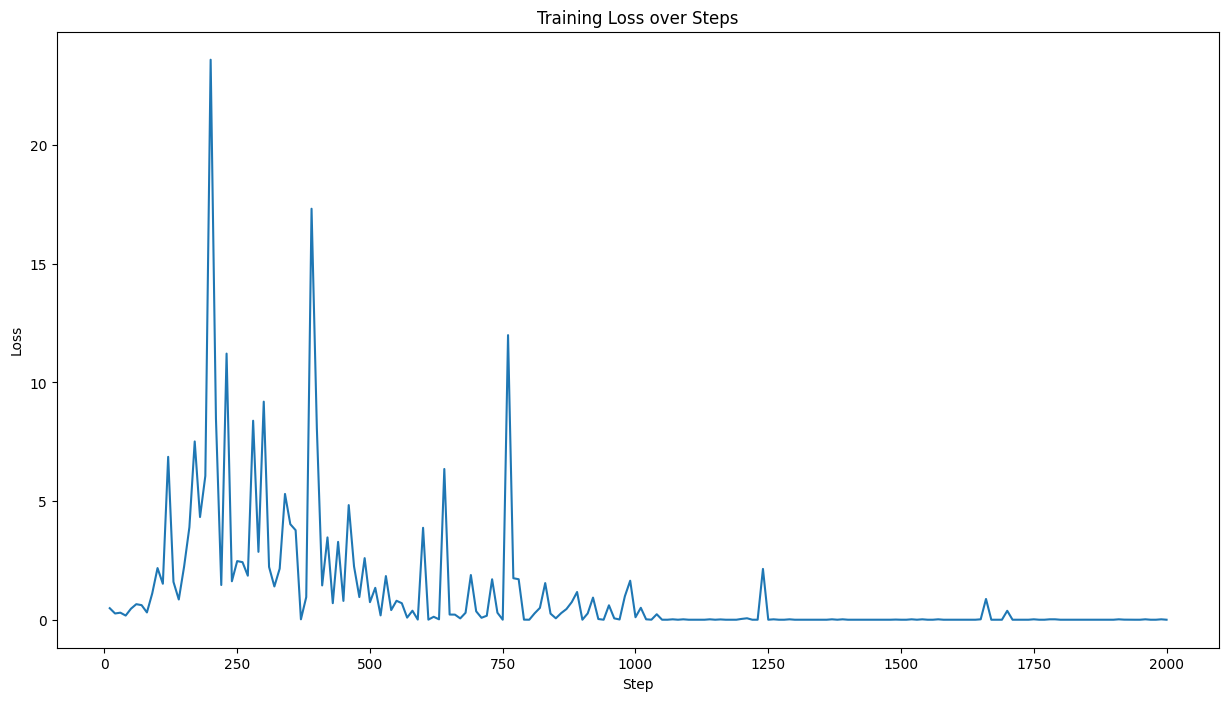

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

df=pd.read_csv('dpo_loss.csv').set_index('Step')
plt.figure(figsize=(15,8))
plt.plot(df['Training Loss'])
plt.ylabel('Loss')
plt.xlabel('Step')
plt.title('Training Loss over Steps')
plt.show()

### The training loss for the DPO model on the IMDB dataset mostly decreases, indicating learning. Periodic spikes suggest challenges with certain data points. Stabilization of loss over time implies some degree of model optimization, though occasional late spikes highlight potential areas for parameter adjustments. Ensuring the model's generalization beyond training data is crucial for real-world application.